# Convolve 3.0

## Problem Statement:

You have been provided with a random sample of **96,806** Credit Card details in  
“Dev_data_to_be_shared.zip”, along with a flag **(bad_flag)** henceforth known as “development 
data”.<br>
This is a historical snapshot of the Credit Card portfolio of Bank A. <br>
**Credit Cards that have actually defaulted have bad_flag = 1.**<br>
You have also been provided with several independent variables.<br>

These include: <br>
- On us attributes like credit limit (varables with names starting with onus_attributes) 
- Transaction level attributes like number of transactions / rupee value transactions on 
various kinds of merchants (variables with names starting with transaction_attribute) 
- Bureau tradeline level attributes (like product holdings, historical delinquencies) – variables 
starting with bureau 
- Bureau enquiry level attributes (like PL enquiries in the last 3 months etc) – variables 
starting with bureau_enquiry.

You have also been provided with another random sample of 41,792 Credit Card details in “validation_data_to_be_shared.zip” with the same set of input variables, but without “bad_flag”. <br>
This will be referred to going forward as “validation data”.

**Your objective is to develop the **Behaviour Score** for Bank A.**

Bank A issues Credit Cards to eligible customers. The Bank deploys advanced ML models and frameworks to decide on eligibility, limit, and interest rate assignment. <br>
The models and frameworks are optimized to manage early risk and ensure profitability.  <br>
The Bank has now decided to build a robust risk management framework for its existing Credit Card customers, irrespective of when they were acquired. <br>
To enable this, the Bank has decided to create a **“Behaviour Score”**. A Behaviour Score is a predictive model. It is developed on a base of customers whose Credit Cards are **open** and are **not past due**. <br>
<br><br>
The model predicts the probability of customers defaulting on the Credit Cards going forward. <br><br>
This model will then be used for several portfolio risk management activities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from imblearn.over_sampling import SMOTE

## EDA

### Read the dataset from the filesystem

In [2]:
card_data = pd.read_csv('./data/Dev_data_to_be_shared.csv')

In [3]:
print(card_data.shape)
card_data.head()

(96806, 1216)


,account_number,bad_flag,onus_attribute_1,transaction_attribute_1,transaction_attribute_2,transaction_attribute_3,transaction_attribute_4,transaction_attribute_5,transaction_attribute_6,transaction_attribute_7,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,221000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,86000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,215000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
card_data = card_data.dropna(axis = 1, how = 'all')

### Assigning to the Independent, non-independent variables

In [5]:
X = card_data.drop('bad_flag', axis = 1)
y = card_data['bad_flag']

### Data preprocessing (Dropping null values, Imputing NaNs with mean imputation, standardising the values)

In [46]:
# Collect columns starting with 'onus', 'transaction', and 'bureau' in separate variables
onus_attr_X = X.filter(like='onus_attribute')
transaction_attr_X = X.filter(like='transaction_attribute')
bureau_attr_X = X.filter(like='bureau')

# Perform mean imputation for onus attributes
imputer_onus = SimpleImputer(strategy='mean')
onus_attr_X_imputed = imputer_onus.fit_transform(onus_attr_X)

# Convert the imputed array back to DataFrame
onus_attr_X_imputed_df = pd.DataFrame(data=onus_attr_X_imputed, columns=onus_attr_X.columns)

# Perform mean imputation for transaction attributes
imputer_transaction = SimpleImputer(strategy='mean')
transaction_attr_X_imputed = imputer_transaction.fit_transform(transaction_attr_X)

# Convert the imputed array back to DataFrame
transaction_attr_X_imputed_df = pd.DataFrame(data=transaction_attr_X_imputed, columns=transaction_attr_X.columns)

# Perform mean imputation for bureau attributes
imputer_bureau = SimpleImputer(strategy='mean')
bureau_attr_X_imputed = imputer_bureau.fit_transform(bureau_attr_X)

# Convert the imputed array back to DataFrame
bureau_attr_X_imputed_df = pd.DataFrame(data=bureau_attr_X_imputed, columns=bureau_attr_X.columns)

# Scaling the imputed array
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
onus_attr_X_imputed_df_scaled = scaler.fit_transform(onus_attr_X_imputed_df)
transaction_attr_X_imputed_df_scaled = scaler.fit_transform(transaction_attr_X_imputed_df)
bureau_attr_X_imputed_df_scaled = scaler.fit_transform(bureau_attr_X_imputed_df)

# Convert the scaled arrays back to DataFrames
onus_attr_X_imputed_df = pd.DataFrame(data=onus_attr_X_imputed_df_scaled, columns=onus_attr_X.columns)
transaction_attr_X_imputed_df = pd.DataFrame(data=transaction_attr_X_imputed_df_scaled, columns=transaction_attr_X.columns)
bureau_attr_X_imputed_df = pd.DataFrame(data=bureau_attr_X_imputed_df_scaled, columns=bureau_attr_X.columns)

# Concatenate the DataFrames
X_selected = pd.concat([onus_attr_X_imputed_df, transaction_attr_X_imputed_df, bureau_attr_X_imputed_df], axis=1)

# Print the shape of the new DataFrame
print(X_selected.shape)
print(X.shape)
print(onus_attr_X.shape, transaction_attr_X.shape, bureau_attr_X.shape)

(96806, 1212)
(96806, 1213)
(96806, 48) (96806, 664) (96806, 500)


### Correlation graph for target variable (bad_flag) with categorical attributes

In [47]:
# Concatenate y with the selected attributes
y_onus_attr_X = pd.concat([y, onus_attr_X_imputed_df], axis=1)
y_transaction_attr_X = pd.concat([y, transaction_attr_X_imputed_df], axis=1)
y_bureau_attr_X = pd.concat([y, bureau_attr_X_imputed_df], axis=1)

# Calculate correlation matrix for each DataFrame
corr_onus_attr_X = y_onus_attr_X.corr()
corr_transaction_attr_X = y_transaction_attr_X.corr()
corr_bureau_attr_X = y_bureau_attr_X.corr()

<Axes: >

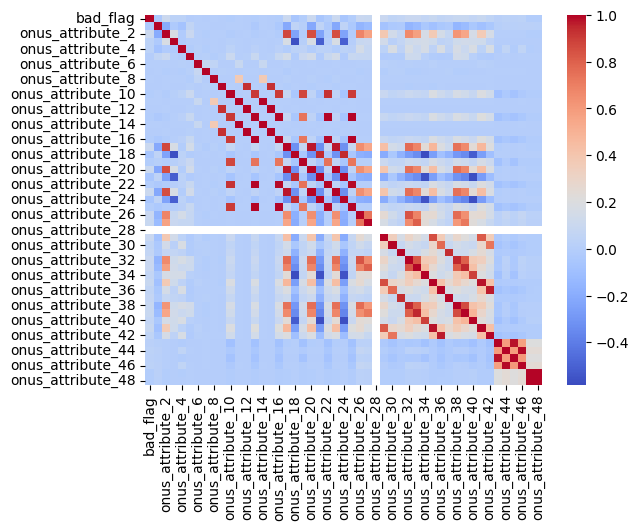

In [48]:
sns.heatmap(corr_onus_attr_X, cmap='coolwarm', annot=False)

<Axes: >

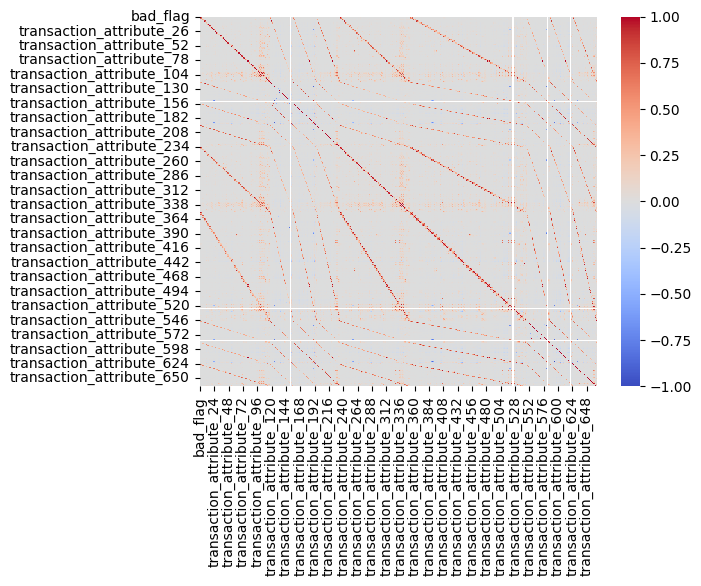

In [49]:
sns.heatmap(corr_transaction_attr_X, cmap='coolwarm', annot=False)

<Axes: >

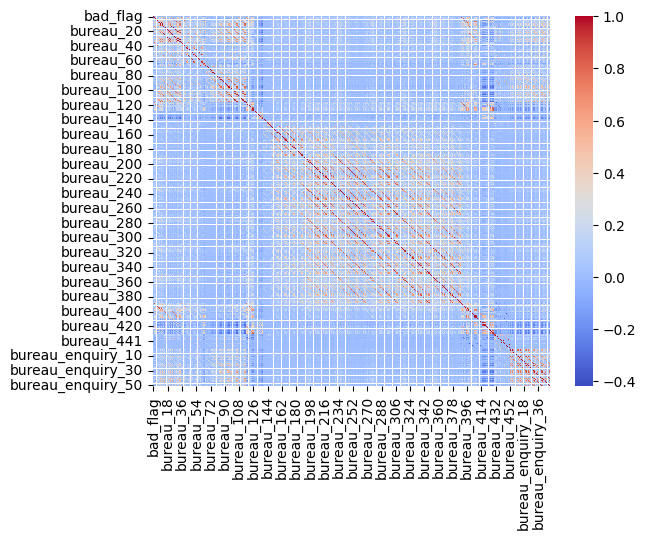

In [50]:
sns.heatmap(corr_bureau_attr_X, cmap='coolwarm', annot=False)

<Axes: >

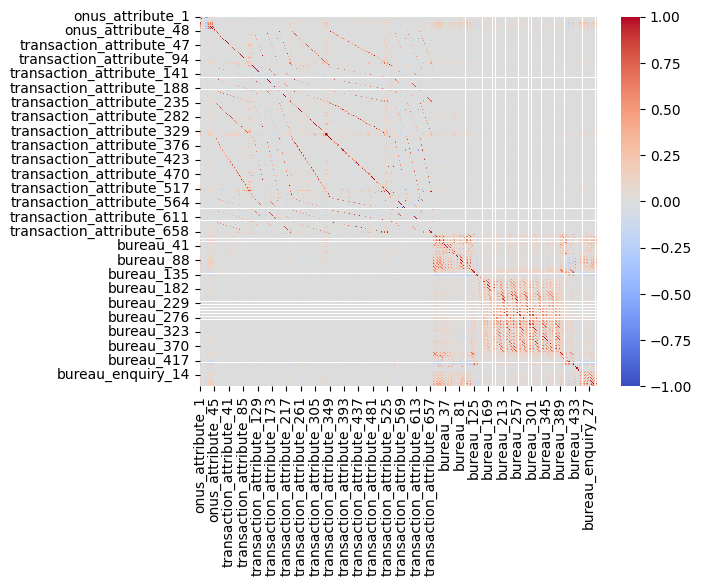

In [51]:
sns.heatmap(X_selected.corr(), cmap='coolwarm', annot=False)

### Categorical statistics

In [52]:
# Calculate mean, std deviation, min, max, sum, and total NaN count for onus attributes
onus_attr_stats = onus_attr_X_imputed_df.agg(['mean', 'std', 'min', 'max', 'sum', 'count']).transpose()
onus_attr_stats['NaN_count'] = onus_attr_X_imputed_df.isnull().sum()

# Calculate mean, std deviation, min, max, sum, and total NaN count for transaction attributes
transaction_attr_stats = transaction_attr_X_imputed_df.agg(['mean', 'std', 'min', 'max', 'sum', 'count']).transpose()
transaction_attr_stats['NaN_count'] = transaction_attr_X_imputed_df.isnull().sum()

# Calculate mean, std deviation, min, max, sum, and total NaN count for bureau attributes
bureau_attr_stats = bureau_attr_X_imputed_df.agg(['mean', 'std', 'min', 'max', 'sum', 'count']).transpose()
bureau_attr_stats['NaN_count'] = bureau_attr_X_imputed_df.isnull().sum()

In [53]:
onus_attr_stats

,mean,std,min,max,sum,count,NaN_count
onus_attribute_1,-1.832030e-16,1.000005,-0.868841,17.786762,-1.773515e-11,96806.0,0
onus_attribute_2,-1.115659e-16,1.000005,-4.170358,3.235635,-1.080025e-11,96806.0,0
onus_attribute_3,-3.009344e-18,1.000005,-0.066796,14.970980,-2.913225e-13,96806.0,0
onus_attribute_4,-3.523134e-17,1.000005,-0.341073,2.931920,-3.410605e-12,96806.0,0
onus_attribute_5,6.459079e-18,1.000005,-0.181481,192.459818,6.252776e-13,96806.0,0
onus_attribute_6,3.578183e-18,1.000005,-176.050954,116.274963,3.463896e-13,96806.0,0
onus_attribute_7,3.523134e-18,1.000005,-0.033860,172.546929,3.410605e-13,96806.0,0
onus_attribute_8,2.201959e-19,1.000005,-245.991754,14.262204,2.131628e-14,96806.0,0
onus_attribute_9,-1.174378e-18,1.000005,-0.018873,275.283901,-1.136868e-13,96806.0,0
onus_attribute_10,-2.399034e-16,1.000005,-1.645496,2.033753,-2.322409e-11,96806.0,0


In [54]:
transaction_attr_stats

,mean,std,min,max,sum,count,NaN_count
transaction_attribute_1,1.394574e-18,1.000005,-0.007352,306.443620,1.350031e-13,96806.0,0
transaction_attribute_2,-2.679050e-18,1.000005,-0.021530,243.811013,-2.593481e-13,96806.0,0
transaction_attribute_3,3.963526e-18,1.000005,-0.015783,212.080366,3.836931e-13,96806.0,0
transaction_attribute_4,-2.201959e-18,1.000005,-40.374899,131.882004,-2.131628e-13,96806.0,0
transaction_attribute_5,-1.306496e-17,1.000005,-0.056693,107.672785,-1.264766e-12,96806.0,0
...,...,...,...,...,...,...,...
transaction_attribute_660,-4.477316e-17,1.000005,-0.987276,205.211091,-4.334311e-12,96806.0,0
transaction_attribute_661,3.890127e-18,1.000005,-1.255866,181.616165,3.765876e-13,96806.0,0
transaction_attribute_662,-2.495553e-18,1.000005,-8.139434,163.995620,-2.415845e-13,96806.0,0
transaction_attribute_663,-5.871890e-19,1.000005,-0.308623,33.518988,-5.684342e-14,96806.0,0


In [55]:
bureau_attr_stats

,mean,std,min,max,sum,count,NaN_count
bureau_1,5.005786e-17,1.000005,-0.394832,77.556676,4.845901e-12,96806.0,0
bureau_2,1.600090e-17,1.000005,-0.580322,24.526252,1.548983e-12,96806.0,0
bureau_3,7.237104e-17,1.000005,-0.427401,26.102152,7.005951e-12,96806.0,0
bureau_4,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,96806.0,0
bureau_5,7.339863e-18,1.000005,-0.563609,16.815255,7.105427e-13,96806.0,0
...,...,...,...,...,...,...,...
bureau_enquiry_46,-5.504897e-17,1.000005,-0.374946,34.988987,-5.329071e-12,96806.0,0
bureau_enquiry_47,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,96806.0,0
bureau_enquiry_48,2.447844e-17,1.000005,-0.321869,30.226050,2.369660e-12,96806.0,0
bureau_enquiry_49,-3.871778e-17,1.000005,-0.121501,38.290889,-3.748113e-12,96806.0,0


## Feature Selection - PCA

In [56]:
# Initialize PCA with 5 components
pca_onus = PCA(n_components=5)

# Fit and transform onus_attr_X using PCA
onus_attr_X_pca = pca_onus.fit_transform(onus_attr_X_imputed_df)

# Convert the PCA result to a DataFrame
onus_attr_X_pca_df = pd.DataFrame(data=onus_attr_X_pca)

In [57]:
# Initialize PCA with 5 components
pca_transaction = PCA(n_components=5)

# Fit and transform transaction_attr_X using PCA
transaction_attr_X_pca = pca_transaction.fit_transform(transaction_attr_X_imputed_df)

# Convert the PCA result to a DataFrame
transaction_attr_X_pca_df = pd.DataFrame(data=transaction_attr_X_pca)

In [58]:
# Initialize PCA with 5 components
pca_bureau = PCA(n_components=5)

# Fit and transform bureau_attr_X using PCA
bureau_attr_X_pca = pca_bureau.fit_transform(bureau_attr_X_imputed_df)

# Convert the PCA result to a DataFrame
bureau_attr_X_pca_df = pd.DataFrame(data=bureau_attr_X_pca)

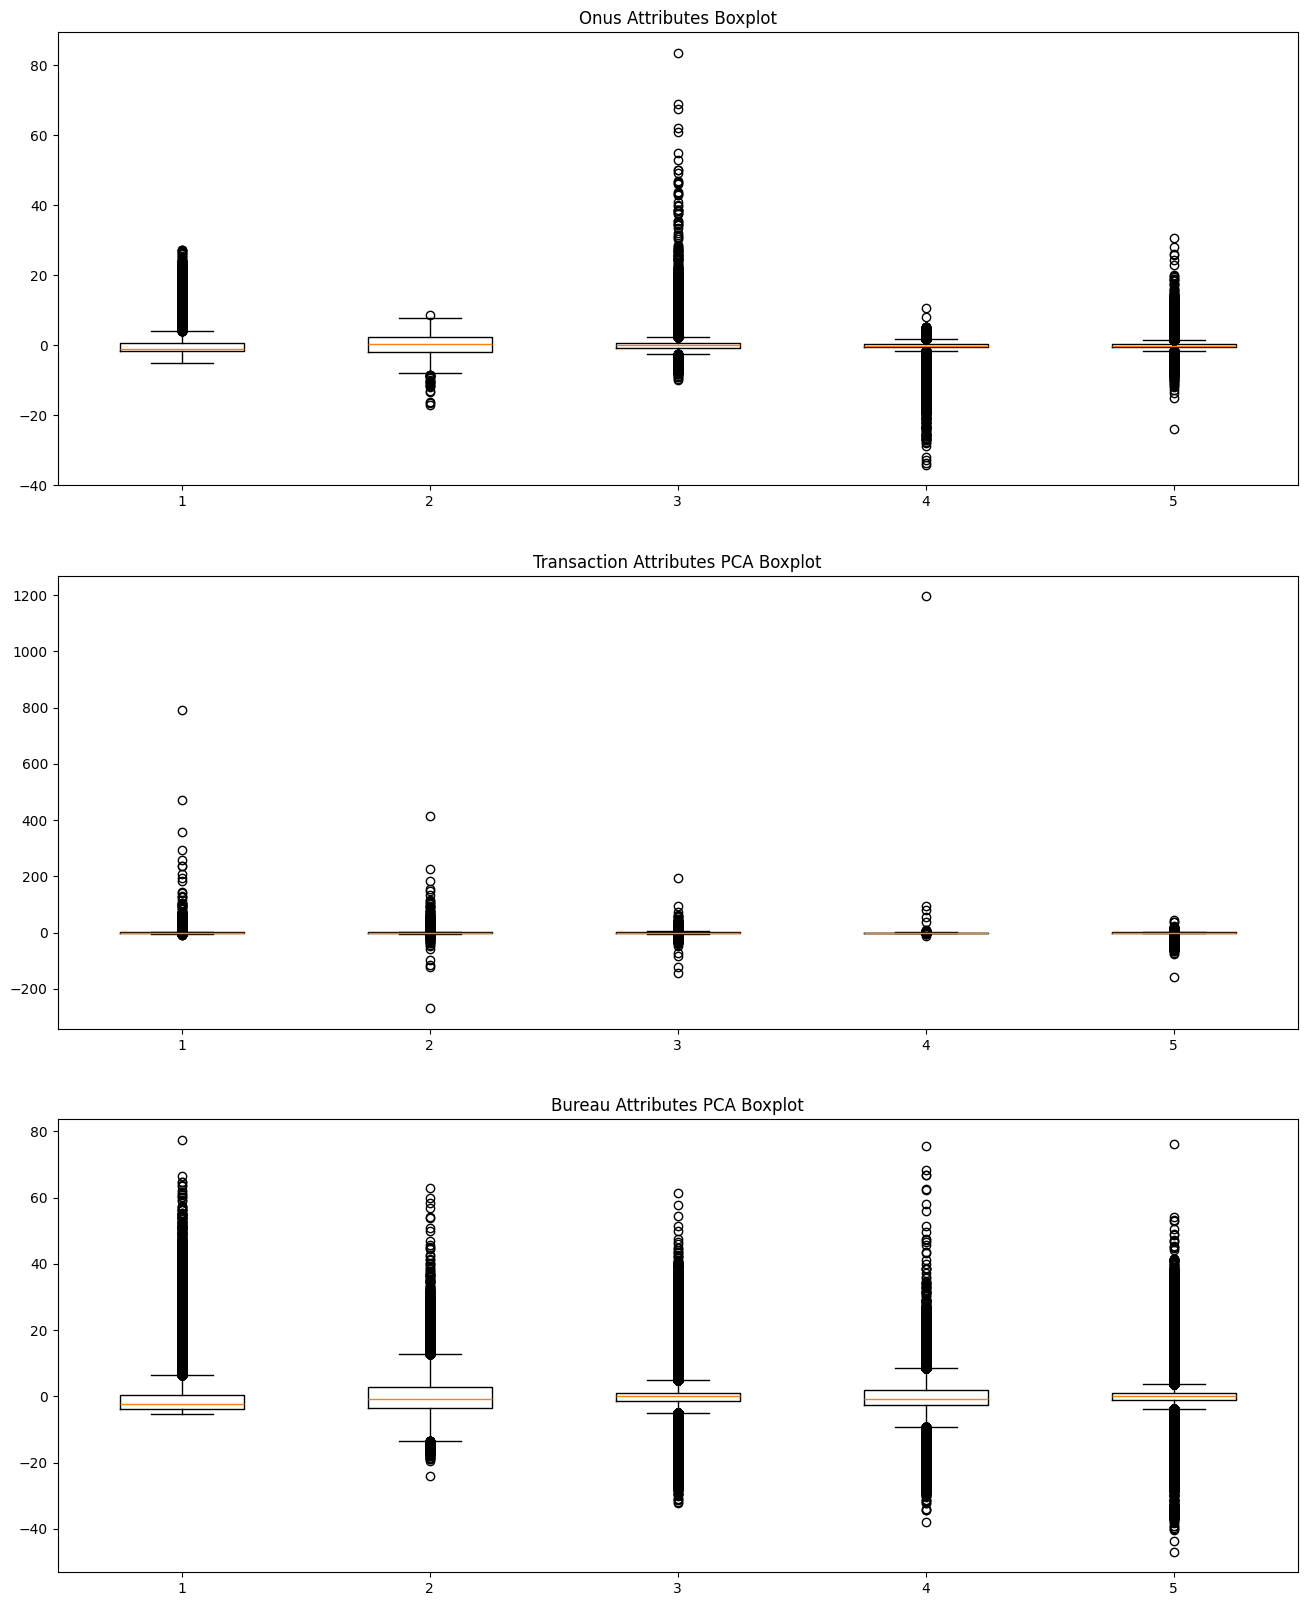

In [59]:
plt.figure(figsize=(16, 20))

# Boxplot for onus attributes
plt.subplot(3, 1, 1)
plt.boxplot(onus_attr_X_pca_df)
plt.title('Onus Attributes Boxplot')

# Boxplot for transaction attributes after PCA
plt.subplot(3, 1, 2)
plt.boxplot(transaction_attr_X_pca_df)
plt.title('Transaction Attributes PCA Boxplot')

# Boxplot for bureau attributes after PCA
plt.subplot(3, 1, 3)
plt.boxplot(bureau_attr_X_pca_df)
plt.title('Bureau Attributes PCA Boxplot')

plt.show()

In [60]:
# Calculate correlation matrix for y with PCA attributes
corr_y_pca_onus = pd.concat([y, onus_attr_X_pca_df], axis=1).corr()
corr_y_pca_transaction = pd.concat([y, transaction_attr_X_pca_df], axis=1).corr()
corr_y_pca_bureau = pd.concat([y, bureau_attr_X_pca_df], axis=1).corr()

Text(0.5, 1.0, 'Correlation Heatmap with PCA Onus Attributes and Bad Flag')

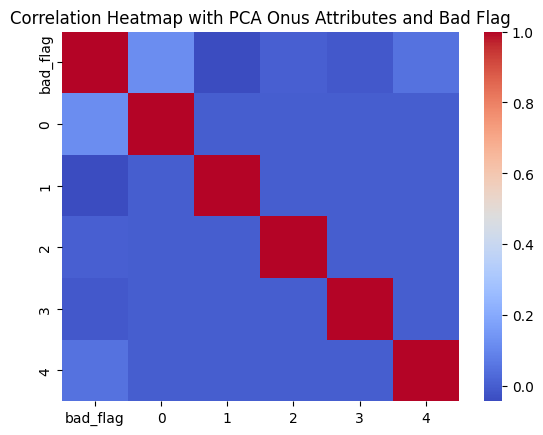

In [61]:
sns.heatmap(corr_y_pca_onus, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap with PCA Onus Attributes and Bad Flag')

Text(0.5, 1.0, 'Correlation Heatmap with PCA Transaction Attributes and Bad Flag')

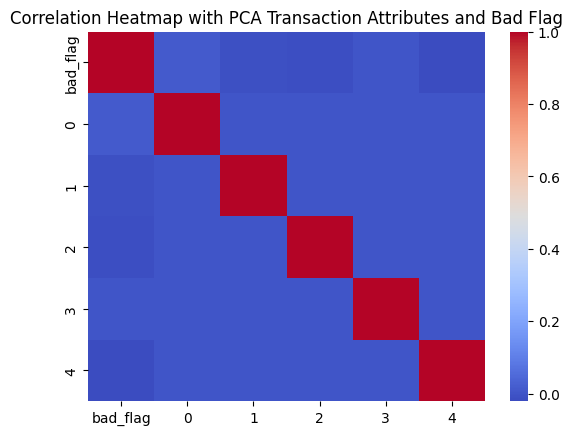

In [62]:
sns.heatmap(corr_y_pca_transaction, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap with PCA Transaction Attributes and Bad Flag')

Text(0.5, 1.0, 'Correlation Heatmap with PCA Bureau Attributes and Bad Flag')

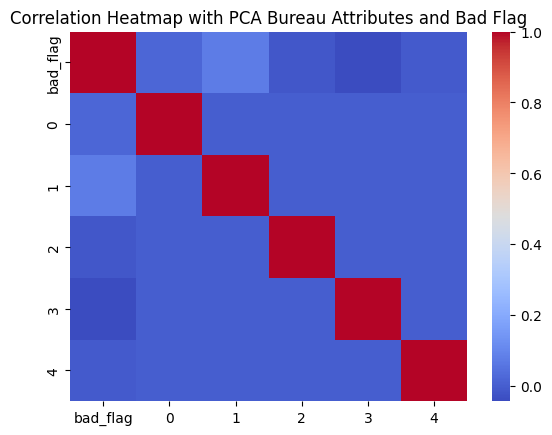

In [63]:
sns.heatmap(corr_y_pca_bureau, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap with PCA Bureau Attributes and Bad Flag')

In [64]:
X_new = pd.DataFrame(data=np.hstack([onus_attr_X_pca_df, transaction_attr_X_pca_df, bureau_attr_X_pca_df]))
y_new = y

print(X_new.shape, )

(96806, 15)


<Axes: >

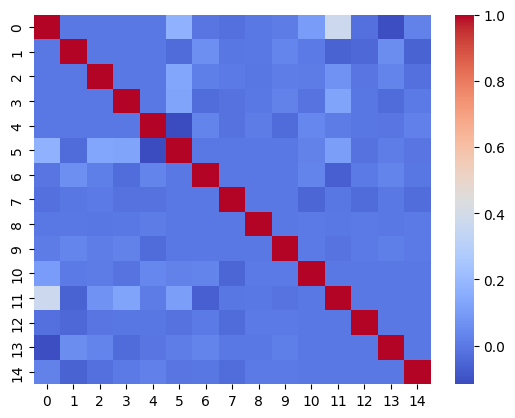

In [65]:
# 
sns.heatmap(X_new.corr(), cmap='coolwarm', annot=False)

## Modeling with Logistic Regression

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, train_size = 0.6, random_state = 42)
#Apply SMOTE
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# Check the new class distribution
print("Before SMOTE:", y_train.value_counts())
print("")
print("After SMOTE:", y_train_smote.value_counts())
print("")
print("X_train original shape:", X_train.shape)
print("")
print("X_train_smote shape:", X_train_smote.shape)

Before SMOTE: bad_flag
0    57262
1      821
Name: count, dtype: int64

After SMOTE: bad_flag
0    57262
1    57262
Name: count, dtype: int64

X_train original shape: (58083, 15)

X_train_smote shape: (114524, 15)


In [67]:
lr1 = LogisticRegression(max_iter = 1000)
lr1.fit(X_train_smote, y_train_smote)
y_pred = lr1.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7525759884306484


In [68]:
y_pred_proba = lr1.predict_proba(X_test)[:, 1]

In [69]:
# Print confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[28765  9407]
 [  174   377]]


In [70]:
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

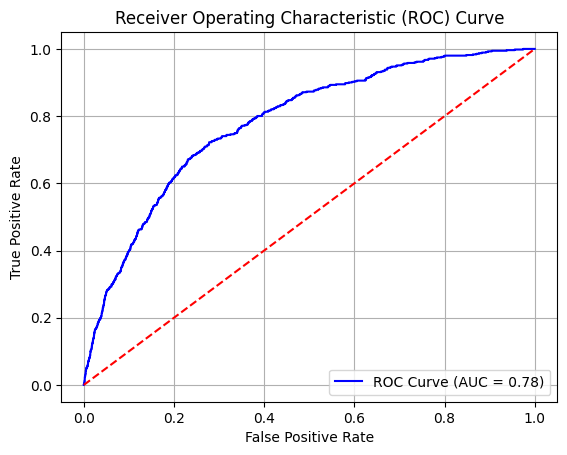

In [71]:
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [72]:
# Calculate accuracy, precision, and recall scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy Score: {accuracy:.2f}")
print(f"Precision Score: {precision:.2f}")
print(f"Recall Score: {recall:.2f}")

Accuracy Score: 0.75
Precision Score: 0.04
Recall Score: 0.68


## Modeling with Random Forest Classifier

In [74]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_clf.fit(X_train_smote, y_train_smote)

# Predict on the test data
y_pred_rf = rf_clf.predict(X_test)

# Print accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy Score (Random Forest): {accuracy_rf:.2f}")

# Print confusion matrix
confusion_mat_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(confusion_mat_rf)

# Calculate AUC-ROC score
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"AUC-ROC Score (Random Forest): {auc_rf:.2f}")

# Calculate precision, recall, and F1-score
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf)
print(f"Precision Score (Random Forest): {precision_rf:.2f}")
print(f"Recall Score (Random Forest): {recall_rf:.2f}")
print(f"F1-Score (Random Forest): {f1_rf:.2f}")

Accuracy Score (Random Forest): 0.97
Confusion Matrix (Random Forest):
[[37619   553]
 [  516    35]]
AUC-ROC Score (Random Forest): 0.73
Precision Score (Random Forest): 0.06
Recall Score (Random Forest): 0.06
F1-Score (Random Forest): 0.06


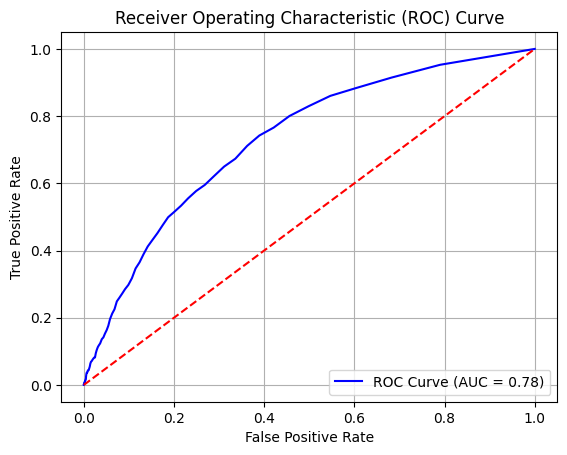

In [78]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color='blue', label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Modeling with Decision Tree

In [75]:
# Apply Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_clf.fit(X_train_smote, y_train_smote)

# Predict on the test data
y_pred_dt = dt_clf.predict(X_test)

# Print accuracy score
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy Score (Decision Tree): {accuracy_dt:.2f}")

# Print confusion matrix
confusion_mat_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix (Decision Tree):")
print(confusion_mat_dt)

# Calculate AUC-ROC score
y_pred_proba_dt = dt_clf.predict_proba(X_test)[:, 1]
auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print(f"AUC-ROC Score (Decision Tree): {auc_dt:.2f}")

# Calculate precision, recall, and F1-score
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = 2 * (precision_dt * recall_dt) / (precision_dt + recall_dt)
print(f"Precision Score (Decision Tree): {precision_dt:.2f}")
print(f"Recall Score (Decision Tree): {recall_dt:.2f}")
print(f"F1-Score (Decision Tree): {f1_dt:.2f}")

Accuracy Score (Decision Tree): 0.92
Confusion Matrix (Decision Tree):
[[35596  2576]
 [  443   108]]
AUC-ROC Score (Decision Tree): 0.56
Precision Score (Decision Tree): 0.04
Recall Score (Decision Tree): 0.20
F1-Score (Decision Tree): 0.07


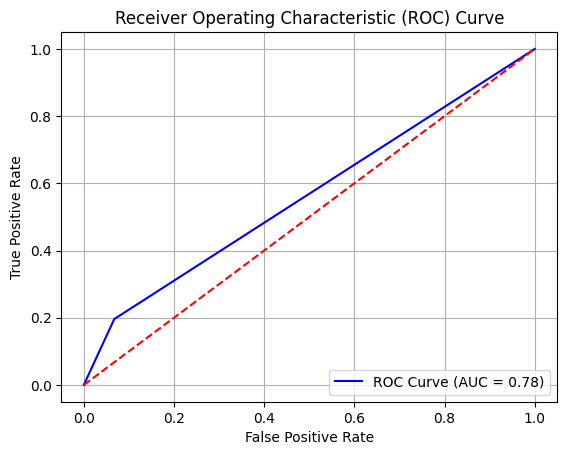

In [79]:
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)

plt.figure()
plt.plot(fpr_dt, tpr_dt, color='blue', label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Modeling with ensemble methods

In [77]:
# Apply ensemble classification method
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Initialize classifiers
lr_clf = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)

# Create an ensemble classifier using VotingClassifier
ensemble_clf = VotingClassifier(estimators=[('lr', lr_clf), ('rf', rf_clf), ('dt', dt_clf), ('gb', gb_clf)], voting='soft')

# Fit the ensemble classifier on the training data
ensemble_clf.fit(X_train_smote, y_train_smote)

# Predict on the test data
y_pred_ensemble = ensemble_clf.predict(X_test)

# Print accuracy score
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Accuracy Score (Ensemble): {accuracy_ensemble:.2f}")

# Print confusion matrix
confusion_mat_ensemble = confusion_matrix(y_test, y_pred_ensemble)
print("Confusion Matrix (Ensemble):")
print(confusion_mat_ensemble)

# Calculate AUC-ROC score
y_pred_proba_ensemble = ensemble_clf.predict_proba(X_test)[:, 1]
auc_ensemble = roc_auc_score(y_test, y_pred_proba_ensemble)
print(f"AUC-ROC Score (Ensemble): {auc_ensemble:.2f}")

# Calculate precision, recall, and F1-score
precision_ensemble = precision_score(y_test, y_pred_ensemble)
recall_ensemble = recall_score(y_test, y_pred_ensemble)
f1_ensemble = 2 * (precision_ensemble * recall_ensemble) / (precision_ensemble + recall_ensemble)
print(f"Precision Score (Ensemble): {precision_ensemble:.2f}")
print(f"Recall Score (Ensemble): {recall_ensemble:.2f}")
print(f"F1-Score (Ensemble): {f1_ensemble:.2f}")

Accuracy Score (Ensemble): 0.93
Confusion Matrix (Ensemble):
[[35729  2443]
 [  417   134]]
AUC-ROC Score (Ensemble): 0.77
Precision Score (Ensemble): 0.05
Recall Score (Ensemble): 0.24
F1-Score (Ensemble): 0.09


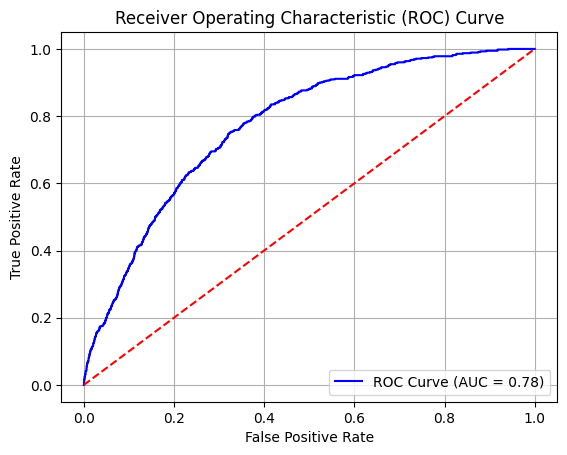

In [80]:
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(y_test, y_pred_proba_ensemble)

plt.figure()
plt.plot(fpr_ensemble, tpr_ensemble, color='blue', label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Applying PCA to all X columns